<a id='Top'></a>
# CLASSIFICATION CHALLENGE

# Outline

- [Introduction](#Introduction)
- [Import necessary libraries](#Import)
- [Loading Datasets](#Load)
- [Data Preprocessing](#section-four)
- EDA
  * Analysis of the data
  
- [Classification Models](#)  
- [Feature Egineering](#feature_engineering)
 * [TF-IDF](#tfidf)
 * [WORD2VEC](word2vec) 
- [Pipelines](#Pipelines)
  * [Building Classification Pipelines](#classifiers)
  * [Using Word2Vec](#pipe_word2vec)
- [Modelling and Evaluation](#model_eval)
  * [Modelling - Raw tweets](#raw_tweets)
  * [Modelling - Cleaned tweets](#clean_tweets)
  * [Model perfomance (raw tweets vs cleaned tweets)](#rvc)
  * [Model perfomance (tfidf vs word2vec)](tfidfvsword2vec)
- [Ensemble Method](#ensemble)
- [Choosing the champion model](#cham_model)
- [Hyperparameter tunning](#hy_tunning)
- [Predictions](#predictions)
- [Submission](#submission)  
- [Conclusion](#conclusion)
- [Appendix](#appendix)
- [References](#references)
    
    


# Introduction

Companies are constructed around lessening ones environment impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. 

**Problen Statement**

Create a Natural Language Processing model to classify whether or not a person believes in climate change, based on their novel tweet data. 

<a id="comet"></a>
# Starting a Comet experiment
<img src="https://www.comet.ml/images/logo_comet_light.png" width="350" alt="Drawing" style="width: 350px;"/>
We will be using Comet as a form of version control throughout the development of our model

In [5]:
# install comet
# !pip install comet_ml

In [6]:
# importing Experiment from comet
# from comet_ml import Experiment

In [7]:
# # Linking our current workspace to comet by creating an experiment with our api key:
# experiment = Experiment(
#     api_key="YBjEZqF3vM9CQLf2Lx7GeSw0C",
#     project_name="general",
#     workspace="mpho-mokhokane",
# )

In [8]:
!pip install contractions

<a id='Import'></a>
# Import necessary libraries

In [9]:
# !pip install parfit
# !pip install scikit-plot

# imports for data visualisation

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()


# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
#from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_roc_curve
import pickle



import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




<a id='Load'></a>
# Load and view the data

In [10]:
# Importing the train & test data sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA Datasets
train_eda = pd.read_csv('train.csv')
test_eda = pd.read_csv('test.csv')

# Data Preprocessing

Identifying Missing Values

In [11]:
train_data = train.copy()
test_data = test.copy()

In [12]:
#Cheching if there are missing values in the Train dataset
train.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
#Cheching if there are missing values in the Test dataset
test.isna().sum()

message    0
tweetid    0
dtype: int64

Removing Mentions

Expand Contractions


In [14]:
train['message'] = train['message'].apply(lambda x: contractions.fix(x))

train.head()

AttributeError: module 'contractions' has no attribute 'fix'

Removing URLs

In [ ]:
train['message'] = train['message'].str.replace('http\S+|www.\S+', '', case=False)

Removing Punctuations

In [ ]:
def remove_punc(x):
  x = re.sub(r"([^A-Za-z0-9]+)"," ",x)
  return x

train['message'] = train['message'].map(lambda x: remove_punc(str(x)))

Tokenization

In [ ]:
nltk.download('punkt')

train['message'] = train['message'].apply(word_tokenize)
train.head()

Removing Retweets

In [ ]:
retweet = 'RT'
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in retweet])
train.head(10)

Conversion to Lower case

In [ ]:
train['message'] = train['message'].apply(lambda x: [word.lower() for word in x])
train.head()

Removing Stopwords

In [ ]:
nltk.download('stopwords')

", ".join(stopwords.words('english'))

In [ ]:
stop_words = set(stopwords.words('english'))
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in stop_words])
train.head()

Lemmatization

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
train['pos_tags'] = train['message'].apply(nltk.tag.pos_tag)
train['wordnet_pos'] = train['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train['message'] = train['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train.head()

Most Frequent Words

In [ ]:
from collections import Counter
cnt = Counter()
for message in train['message'].values:
    for word in message:
        cnt[word] += 1
        
cnt.most_common()

Separate Datframes of Tweets for each Sentiment

In [15]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [16]:
#sentiment value 0
sentiment_0 = train[train['sentiment'] == 0]
sentiment_0.head()

,sentiment,message,tweetid
19,0,Calum: *tweets abt reunitingish w the cast*\n-...,547924
22,0,"we also met this guy, he let us in on some tru...",67545
30,0,@Jnp_Ftw are these the same scientists that de...,365051
39,0,We’ ve dealt with simple issues like climate c...,403368
43,0,RT @andrewsharp: Win probability is bullshit m...,326916


In [17]:
#sentiment value 1
sentiment_1 = train[train['sentiment'] == 1]
sentiment_1.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577


In [18]:
#sentiment value 2
sentiment_2 = train[train['sentiment'] == 2]
sentiment_2.head()

,sentiment,message,tweetid
2,2,RT @RawStory: Researchers say we have three ye...,698562
12,2,RT @tveitdal: We only have a 5 percent chance ...,454673
14,2,Fossil fuel giant ExxonMobil ‘misled’ the publ...,658092
26,2,Bangladesh confronting climate change head on ...,365291
32,2,RT @latimes: Atmospheric rivers fueled by clim...,143471


In [19]:
#sentiment value -1
sentiment__1 = train[train['sentiment'] == -1]
sentiment__1.head()

,sentiment,message,tweetid
28,-1,Sally Kohn’s latest evidence of climate change...,355491
46,-1,@realDonaldTrump Carbon Tax is a Globalist ide...,61141
48,-1,RT @SteveSGoddard: We had winds close to 100 M...,719523
56,-1,@MissLizzyNJ lmao 😂 snowflakes ❄️ complaining ...,911385
57,-1,RT @Dawn2334Dawn: This is ONE of Arnold Schwar...,768263


# Exploratory Data Analysis

In this section we want to apply a variety of techniques to maximize specific insights into our dataset, reveal underlying structure, extract significant variables, detect outliers and anomalies, test assumptions and determine best parameters for estimations. In essence, we want to dig deeper into our dataset to more insights about its behaviour!

### Explore the target variable

We want to understand the behaviour of our target variable for our respective categories...let's dig in ⛏!

In [20]:
# Map the target variable name to their code for better understanding

train_eda['sent_labels']  = train_eda['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})

In [21]:
#Confirm the dataset
train_eda.head()

,sentiment,message,tweetid,sent_labels
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,Pro
1,1,It's not like we lack evidence of anthropogeni...,126103,Pro
2,2,RT @RawStory: Researchers say we have three ye...,698562,News
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,Pro
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,Pro


In [22]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentiment    15819 non-null  int64 
 1   message      15819 non-null  object
 2   tweetid      15819 non-null  int64 
 3   sent_labels  15819 non-null  object
dtypes: int64(2), object(2)
memory usage: 494.5+ KB


Percentage contribution:
 Pro        53.922498
News       23.010304
Neutral    14.874518
Anti        8.192680
Name: sent_labels, dtype: float64


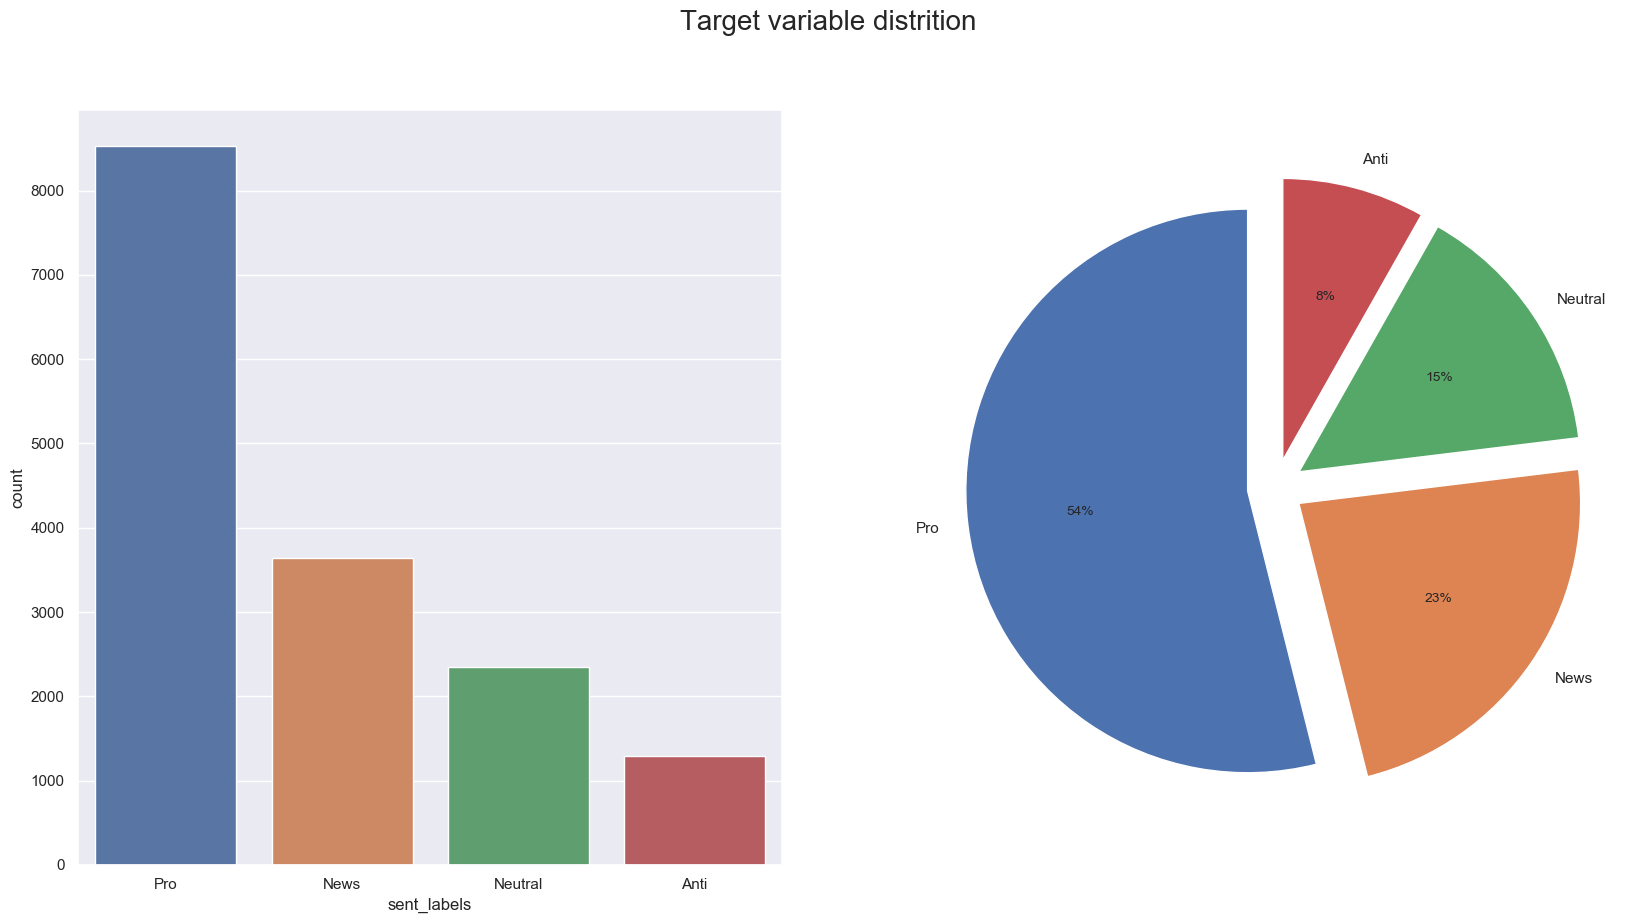

In [23]:
# Display target distribution

print("Percentage contribution:\n",train_eda.sent_labels.value_counts(normalize=True)*100)

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(train_eda['sent_labels'], ax=axes[0])

code_labels=['Pro', 'News', 'Neutral', 'Anti']
axes[1].pie(train_eda['sent_labels'].value_counts(),
            labels= code_labels,
            autopct='%1.0f%%',
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Target variable distrition', fontsize=20)
plt.show()

In [24]:
# Get the length of each message for each class
train_eda['text_length'] = train_eda['message'].apply(lambda x: len(x))
train_eda.head()

,sentiment,message,tweetid,sent_labels,text_length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,Pro,140
1,1,It's not like we lack evidence of anthropogeni...,126103,Pro,62
2,2,RT @RawStory: Researchers say we have three ye...,698562,News,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,Pro,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,Pro,122


## Visualize tweet length for each class 

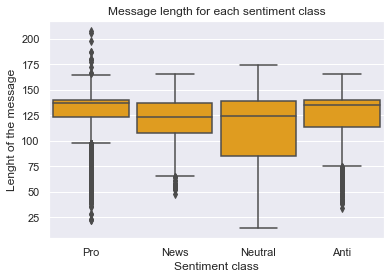

In [25]:
sns.boxplot(x=train_eda['sent_labels'], y=train_eda['text_length'], data=train_eda, width = 0.9, color = 'orange')
plt.ylabel('Lenght of the message')
plt.xlabel('Sentiment class')
plt.title('Message length for each sentiment class')
plt.show()

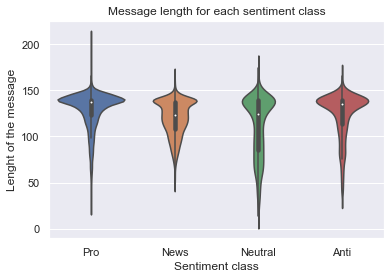

In [26]:
# Count the text length for each class type
sns.violinplot(x="sent_labels", y="text_length", data=train_eda)
plt.ylabel('Lenght of the message')
plt.xlabel('Sentiment class')
plt.title('Message length for each sentiment class')
plt.show()

##### Quick observations:
* There are no missing values for our target data, including the feature message.
* There is a strong imbalance for sentiment classes
* Sentiment class '1' (Pro) dominates the chart with over 50% contribution, while class '-1' (Anti) lags behind with 8%.
* Sentiment Class Pro has a outliers on both, the upper an lower bound. 

## Investigate the feature variable

At this stage we want to understand the message and its contents much better, to draw fruitful insghts about our target variable. 

### Sentiment Analysis

Sentiment analysis is a technique that detects the underlying sentiment in a piece of text. It is the process of classifying text as either positive, negative, or neutral. The values range from 1 to -1; with positivity decreasing from 1 to -1, having a neutral sentiment at 0.

![Alt_text](https://miro.medium.com/max/687/1*FRd4BsrZ2VxKLbvVYJQC6w.png)


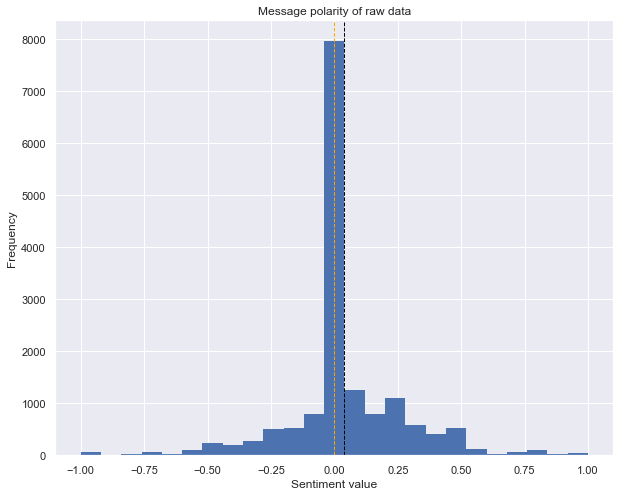

In [27]:
#Compare the sentiment analysis from raw data

from textblob import TextBlob
train_eda['polarity']=train_eda['message'].apply(lambda x:
                                             TextBlob(x).sentiment.polarity)

plt.figure(figsize=[10, 8])
plt.hist(train_eda['polarity'], bins=25, linewidth=0)
plt.gca().set(title='Message polarity of raw data',
              ylabel='Frequency', xlabel = 'Sentiment value')
plt.axvline(train_eda['polarity'].mean(), color='black',
            linestyle='dashed', linewidth=1)
plt.axvline(train_eda['polarity'].median(), color='orange',
            linestyle='dashed', linewidth=1)

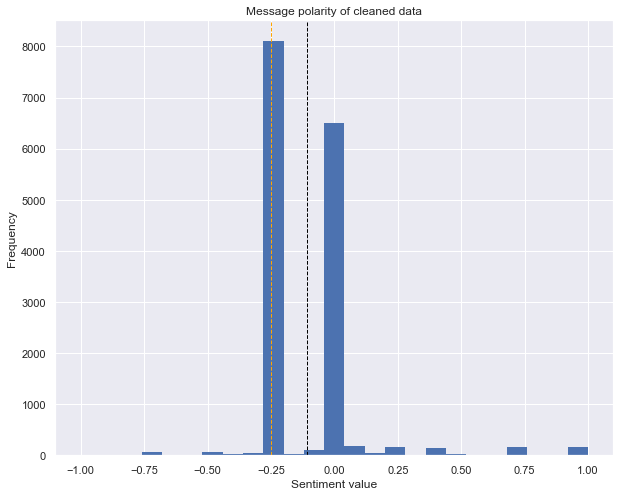

In [28]:
#Compare the sentiment analysis from cleaned data

# Convert the cleaned message from list to string
train_eda['message'] = train['message'].str.join(' ')

train['polarity']=train_eda['message'].apply(lambda x:
                                             TextBlob(x).sentiment.polarity)

plt.figure(figsize=[10, 8])
plt.hist(train['polarity'], bins=25, linewidth=0)
plt.gca().set(title='Message polarity of cleaned data',
              ylabel='Frequency', xlabel = 'Sentiment value')
plt.axvline(train['polarity'].mean(), color='black',
            linestyle='dashed', linewidth=1)
plt.axvline(train['polarity'].median(), color='orange',
            linestyle='dashed', linewidth=1)

###### Observation 
- Positively skewed sentiments, mean is greater than median.
- Majority of the tweets are around neutral sentiment
- Cleaned data has a greater mean than raw data; however, the central tendency show a similar trend for both. 
- This is an assurance that we didn't dilute the behaviour our data from cleaning it.

### Infiltrate text analysis
From here, we want to dig deeper into our text and investigate each word individually and its frequency of use. 

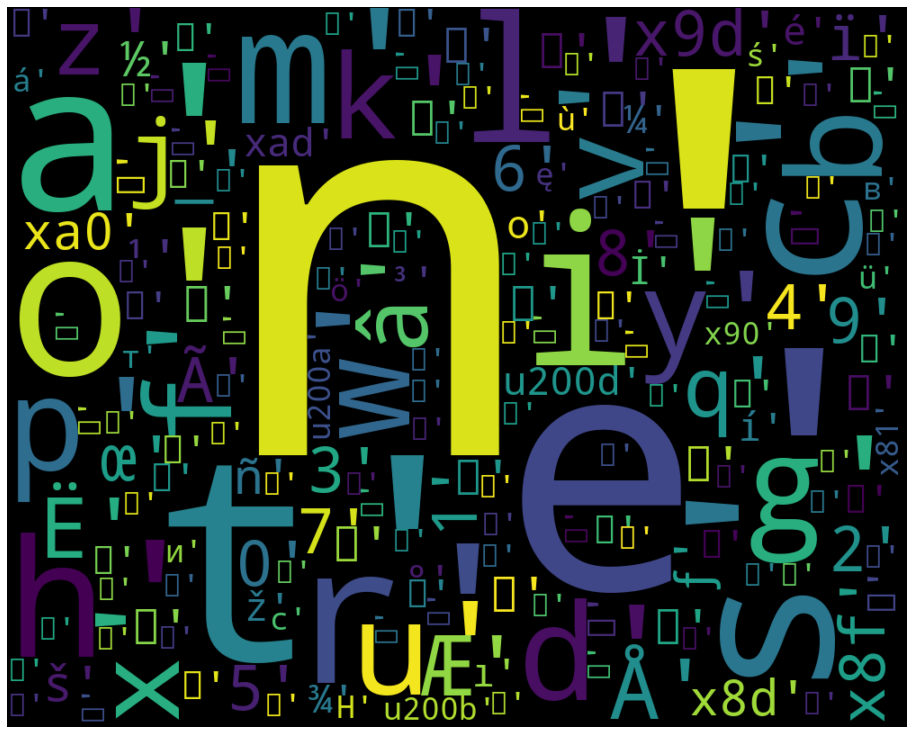

In [29]:
# WordCloud for cleaned data

from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

words = train['message']
allwords = []
for wordlist in words:
    allwords += wordlist
    
mostcommon = FreqDist(allwords).most_common(10000)
wordcloud = WordCloud(width=1000, height=800, background_color=
                      'black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

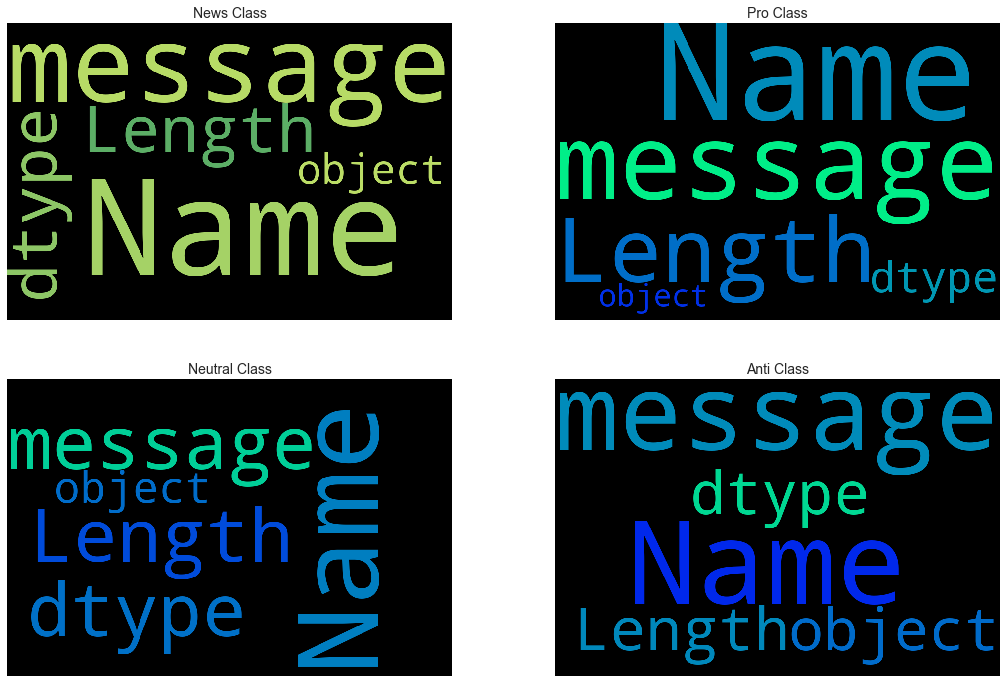

In [30]:
# Convert list to strings for each sentiment class
news = train['message'][train_eda['sentiment']==2].str.join(' ')
neutral = train['message'][train_eda['sentiment']==2].str.join(' ')
pro = train['message'][train_eda['sentiment']==2].str.join(' ')
anti = train['message'][train_eda['sentiment']==2].str.join(' ')

#Visualize each sentiment class

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

news_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='summer').generate(str(news))
axis[0, 0].imshow(news_wordcloud)
axis[0, 0].set_title('News Class',fontsize=14)
axis[0, 0].axis("off") 

neutral_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(neutral))
axis[1, 0].imshow(neutral_wordcloud)
axis[1, 0].set_title('Neutral Class',fontsize=14)
axis[1, 0].axis("off") 

pro_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(pro))
axis[0, 1].imshow(pro_wordcloud)
axis[0, 1].set_title('Pro Class',fontsize=14)
axis[0, 1].axis("off") 

anti_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(anti))
axis[1, 1].imshow(anti_wordcloud)
axis[1, 1].set_title('Anti Class',fontsize=14)
axis[1, 1].axis("off") 

plt.show()

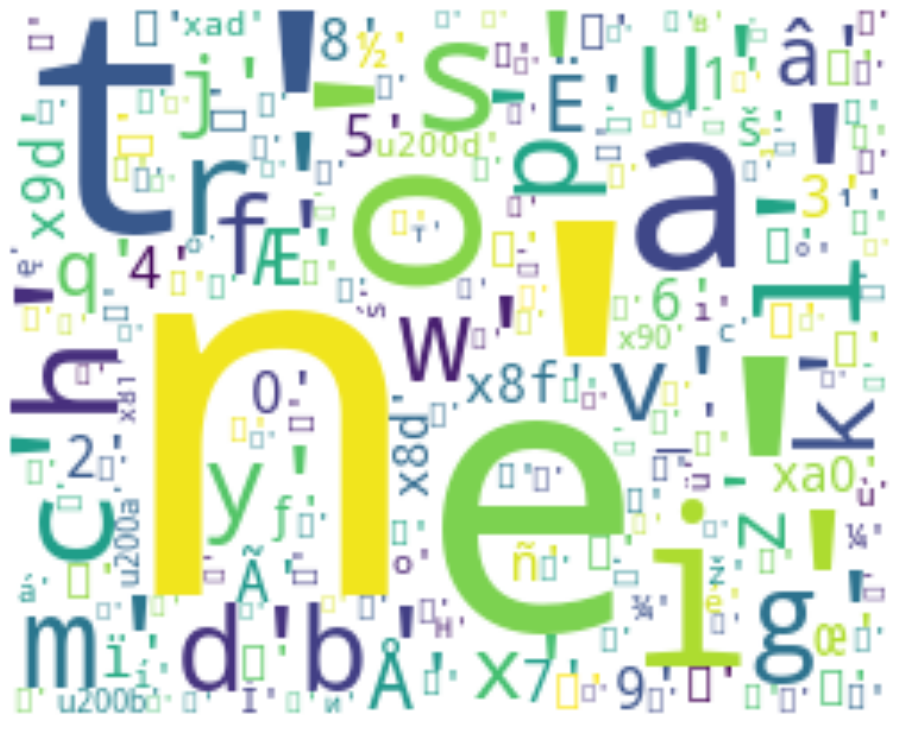

In [32]:
# WordCloud for cleaned data
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
mask = np.array(Image.open('Twitter.png'))
words = train['message']
allwords = []
for wordlist in words:
    allwords += wordlist
mostcommon = FreqDist(allwords).most_common(10000)
wordcloud = WordCloud(width=1000, height=1000, background_color=
                      'white',mask=mask).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Extract the top 20 most used words in each class

### Extract the hastags

In [106]:
# Get hashtags from raw data

train_eda = pd.read_csv('train.csv')
train_eda['no_stopwords'] = train_eda['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

hashtag = [item for item in train_eda['no_stopwords'].str.split() if item[0].startswith('#')]
hashtag = sum(hashtag, [])
count = nltk.FreqDist(hashtag)  
hashtag = pd.DataFrame({'hashtags': list(count.keys()),
                       'count': list(count.values())})
hashtag = hashtag.nlargest(20, columns="count")

hashtag.head()

,hashtags,count
7,climate,143
8,change,120
17,global,40
18,warming,21
49,-,21


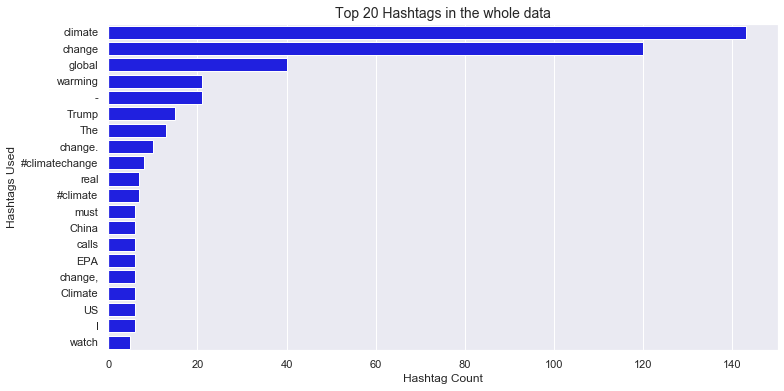

In [107]:
#Visualize the hastag count

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=hashtag, y ='hashtags', x ='count', orient='h', color = 'blue')
plt.title('Top 20 Hashtags in the whole data',fontsize=14)
plt.xlabel('Hashtag Count')
plt.ylabel('Hashtags Used')
plt.show()

### Top 20 Hashtags for each of the sentiment class

In [108]:
#Start-off by sorting the dataframe for each sentiment class

# News
news_hashtag = [item for item in train_eda['no_stopwords'][train_eda['sentiment'] == 2].str.split() if item[0].startswith('#')]
news_hashtag = sum(news_hashtag, [])
count = nltk.FreqDist(news_hashtag)  
news_hashtag = pd.DataFrame({'news_hashtags': list(count.keys()),
                       'count': list(count.values())})
news_hashtags = news_hashtag.nlargest(10, columns="count")

# Pro
pro_hashtag = [item for item in train_eda['no_stopwords'][train_eda['sentiment'] == 1].str.split() if item[0].startswith('#')]
pro_hashtag = sum(pro_hashtag, [])
count = nltk.FreqDist(pro_hashtag)  
pro_hashtag = pd.DataFrame({'pro_hashtags': list(count.keys()),
                       'count': list(count.values())})
pro_hashtags = pro_hashtag.nlargest(10, columns="count")

# Neutral
neut_hashtag = [item for item in train_eda['no_stopwords'][train_eda['sentiment'] == 0].str.split() if item[0].startswith('#')]
neut_hashtag = sum(neut_hashtag, [])
count = nltk.FreqDist(neut_hashtag)  
neut_hashtag = pd.DataFrame({'neutral_hashtags': list(count.keys()),
                       'count': list(count.values())})
neutral_hashtags = neut_hashtag.nlargest(10, columns="count")

# Anti
anti_hashtag = [item for item in train_eda['no_stopwords'][train_eda['sentiment'] == -1].str.split() if item[0].startswith('#')]
anti_hashtag = sum(anti_hashtag, [])
count = nltk.FreqDist(anti_hashtag)  
anti_hashtag = pd.DataFrame({'anti_hashtags': list(count.keys()),
                       'count': list(count.values())})
anti_hashtags = anti_hashtag.nlargest(10, columns="count")

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

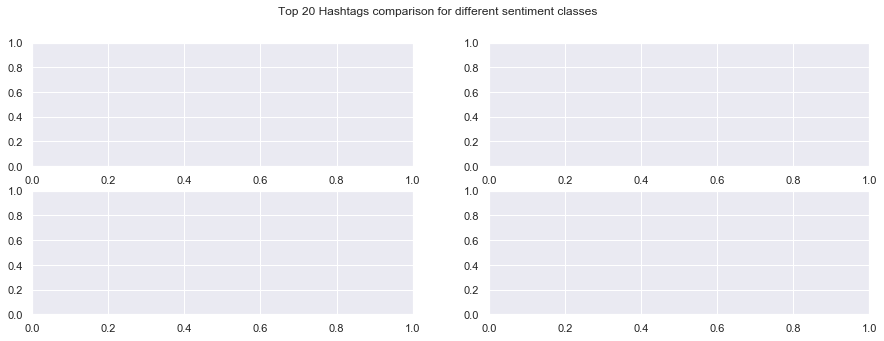

In [149]:
#fig, axis = plt.subplots(2, 2,figsize=[25,10])
#axis = axis.flatten()


fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Top 20 Hashtags comparison for different sentiment classes')

# News
sns.barplot(ax=axes[0], x= news_hashtags['news_hashtags'], y=news_hashtags['count'])
axes[0].set_title('News Hashtags')

# Pro
sns.barplot(ax=axes[1], x= pro_hashtags['pro_hashtags'], y=pro_hashtags['count'])
axes[1].set_title('Pro Hashtags')

# Neutral
sns.barplot(ax=axes[3], x= neutral_hashtags['neutral_hashtags'], y=neutral_hashtags['count'])
axes[0].set_title('Neutral Hashtags')

# Anti
sns.barplot(ax=axes[0], x= anti_hashtags['anti_hashtags'], y= anti_hashtags['count'])
axes[0].set_title('Anti Hashtags')

plt.show()

##### Quick observation
- Climate, change, global, warming are the top 4 words used in the hashtags which is what is expected as these are the key words in ensuring that the tweets are easy to find. 
- There is a [relationship](https://www.azocleantech.com/article.aspx?ArticleID=3) between climate change change and global warming, which explains why 'global' and 'warming' are in the top 4 of hashtags.

### Named Entity Recognition
- Identify the names of people and organizations that are most included in each sentiment class.

In [112]:
train_eda.head()

,sentiment,message,tweetid,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's like lack evidence anthropogenic global w...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT @RawStory: Researchers say three years act ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 pivotal year war c...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT @SoyNovioDeTodas: It's 2016, racist, sexist..."


In [110]:
import en_core_web_sm

nlp = en_core_web_sm.load()
nlp.max_length = 4000000

In [125]:
train['sent_labels']  = train['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})
train.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos,polarity,sent_labels
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi...",0.255556,Pro
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop...",0.000000,Pro
2,2,"[researcher, say, three, year, act, climate, c...",698562,"[(researchers, NNS), (say, VBP), (three, CD), ...","[(researchers, n), (say, v), (three, n), (year...",-0.300000,News
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi...",0.500000,Pro
4,1,"[2016, racist, sexist, climate, change, deny, ...",466954,"[(2016, CD), (racist, NN), (sexist, NN), (clim...","[(2016, n), (racist, n), (sexist, n), (climate...",0.000000,Pro


In [33]:
#PEOPLE INCLUDED IN PRO SENTIMENT
train_pro = train[train['sent_labels'] == 'Pro']
tokens = nlp(''.join(str(train_pro['message'].tolist())))
items = [word.text for word in tokens.ents]

person_list = []
for ent in tokens.ents:
    if ent.label_ =='PERSON':
         person_list.append(ent.text)

person_counts = Counter(person_list).most_common()

df_pro = pd.DataFrame(person_counts, columns=['person','count'])

df_pro.head(15)

KeyError: 'sent_labels'

In [ ]:
#PEOPLE INCLUDED IN ANTI SENTIMENT
train_anti = train[train['sent_labels'] == 'Anti']
tokens = nlp(''.join(str(train_anti['message'].tolist())))
items = [word.text for word in tokens.ents]

person_list = []
for ent in tokens.ents:
    if ent.label_ =='PERSON':
         person_list.append(ent.text)

person_counts = Counter(person_list).most_common()

df_anti = pd.DataFrame(person_counts, columns=['person','count'])

df_anti.head()

In [ ]:
#PEOPLE INCLUDED IN NEUTRAL SENTIMENT
train_neutral = train[train['sent_labels'] == 'Neutral']
tokens = nlp(''.join(str(train_neutral['message'].tolist())))
items = [word.text for word in tokens.ents]

person_list = []
for ent in tokens.ents:
    if ent.label_ =='PERSON':
         person_list.append(ent.text)

person_counts = Counter(person_list).most_common()

df_neutral = pd.DataFrame(person_counts, columns=['person','count'])

df_neutral.head()

In [ ]:
#PEOPLE INCLUDED IN NEWS SENTIMENT
train_news = train[train['sent_labels'] == 'News']
tokens = nlp(''.join(str(train_news['message'].tolist())))
items = [word.text for word in tokens.ents]

person_list = []
for ent in tokens.ents:
    if ent.label_ =='PERSON':
         person_list.append(ent.text)

person_counts = Counter(person_list).most_common()

df_news = pd.DataFrame(person_counts, columns=['person','count'])

df_news.head()

In [ ]:
train_pro = train[train['sent_labels'] == 'Pro']
tokens = nlp(''.join(str(train_pro['message'].tolist())))
items = [word.text for word in tokens.ents]

org_list = []
for ent in tokens.ents:
    if ent.label_ =='ORG':
        org_list.append(ent.text)

org_counts = Counter(org_list).most_common()

df_org_pro = pd.DataFrame(org_counts, columns=['organization','count'])

df_org_pro.head()

In [135]:
#ORGANIZATIONS
train_news = train[train['sent_labels'] == 'News']
tokens = nlp(''.join(str(train_news['message'].tolist())))
items = [word.text for word in tokens.ents]

org_list = []
for ent in tokens.ents:
    if ent.label_ =='ORG':
        org_list.append(ent.text)

org_counts = Counter(org_list).most_common()

df_org = pd.DataFrame(org_counts, columns=['organization','count'])

df_org.head()


,organization,count
0,epa,250
1,cnn,29
2,un,26
3,nasa,22
4,exxon,19


In [136]:
train_neutral = train[train['sent_labels'] == 'Neutral']
tokens = nlp(''.join(str(train_neutral['message'].tolist())))
items = [word.text for word in tokens.ents]

org_list = []
for ent in tokens.ents:
    if ent.label_ =='ORG':
        org_list.append(ent.text)

org_counts = Counter(org_list).most_common()

df_org_neutral= pd.DataFrame(org_counts, columns=['organization','count'])

df_org_neutral.head()

,organization,count
0,epa,19
1,un,16
2,bear',13
3,gon,8
4,cnn,6


In [137]:
train_anti = train[train['sent_labels'] == 'Anti']
tokens = nlp(''.join(str(train_anti['message'].tolist())))
items = [word.text for word in tokens.ents]

org_list = []
for ent in tokens.ents:
    if ent.label_ =='ORG':
        org_list.append(ent.text)

org_counts = Counter(org_list).most_common()

df_org_anti = pd.DataFrame(org_counts, columns=['organization','count'])

df_org_anti.head()

,organization,count
0,epa,16
1,cnn,10
2,un,5
3,islam,4
4,bear',3


<a id='basemodels'></a>
# Classification Models
We're going to look at the following models,

*  Decision Tree Classifier<a id='DS'></a>
*  RandomForest Classifier<a id='random'></a>
*  LinearSVC(Support Vector Classifier)<a id='svc'></a>
*  LGBMClassifier(Light Gradient Boosting Machine Classifier)<a id='LGBM'></a>
*  Logistic Regression
*  Stochastic
*  Support Vector Classifier

<a id='tree'></a>
## Tree-based Models for Classification

<a id='DC'></a>
### Decision Tree Classifier

![1*bcLAJfWN2GpVQNTVOCrrvw.png](https://miro.medium.com/max/688/1*bcLAJfWN2GpVQNTVOCrrvw.png)
Decision Trees (DTs) are  non-parametric supervised learning methods used for classification and regression. Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

Decision tree builds classification or regression models in the form of a tree structure. It breaks down data by partitioning it into subsets after each decision while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.

Visual representation of a `Decision Tree`
![1*WerHJ14JQAd3j8ASaVjAhw.jpeg](https://miro.medium.com/max/963/1*WerHJ14JQAd3j8ASaVjAhw.jpeg)


Decision trees are prone to overfitting. Overfitting happens when the learning algorithm continues to develop hypotheses that reduce training set error at the cost of an increased test set error; One method to tackle overfitting in decision trees is by **prunning**.
There are several approaches used to avoid overfitting in building decision trees namely, 		
- Pre-pruning that stops growing the tree earlier, before it perfectly classifies the training set.
- Post-pruning that allows the tree to perfectly classify the training set, and then post prune the tree. 
Practically, the second approach of post-pruning overfit trees is more successful because it is not easy to precisely estimate when to stop growing the tree.

Decision Trees are building blocks for the next machine learning method we will look into, which is the **Random Forest Classifier**

<a id='random'></a>
### Random Forest Classifier
`Random forest` is a supervised learning algorithm that can be used both for classification and regression. A forest is comprised of a number of individual trees. It is said that the more trees it has, the more robust a forest is, unlike decision trees `Random Forest`  prevents overfitting by creating trees on random subsets  

The Random forest algorithm works in four steps

 1. Selects a number of random samples from a given dataset
 2. Construct a decision tree for each sample and get a prediction result from each decision tree
 3. Perform a vote for each predicted result.
 4. Select the prediction result with the most votes as the final prediction.

a visual representation of a Random Forest classifier is seen in the diagram below
![voting_dnjweq.jpg](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)





## Support Vector Classification(LinearSVC)
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes as seen in the diagram below

![1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg](https://miro.medium.com/max/963/1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg)

To better explain the concept of `SVM` we will look at a case of two classes.

**To find the best line seperating the classes**

The `SVM` algorithm finds the points closest to the line from both the classes.These points are called support vectors, then it compute the distance between the line and the support vectors, This distance is called the margin. Our goal is to maximize the margin.

In a case for more than two classes the goal is to find the the best hyperplane that seperates the classes.
The hyperplane for which the margin is maximum is the optimal hyperplane.

Below is a visual representation of how `SVMs` work

<p float="left">
  <img src="https://miro.medium.com/max/880/1*VDATmWG1E1ZNg7hdasOh5g.png" width="300" />
  <img src="https://miro.medium.com/max/880/1*AMR3v-jCvUMXPUtQskzxmQ.png" width="300" />
  <img src="https://miro.medium.com/max/880/1*irg_jfdAar9gfe0j-Q04vQ.png" width="300" />
</p>





## Light Gradient Boosting Machine(LightGBM)
LightGBM is a gradient boosting framework that also uses a tree based learning algorithm. LightGBM differes from other tree based algorithms in the sense that it grows trees vertifically while other algorithms grow them horizontally, this means that Light GBM grows trees leaf-wise while other algorithm grow level-wise.

LightGBM will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.
The diagrams below explain the implementation of LightGBM and other boosting algorithms


How Light GBM works![1*AZsSoXb8lc5N6mnhqX5JCg.png](https://miro.medium.com/max/875/1*AZsSoXb8lc5N6mnhqX5JCg.png)

How other tree based algorithms work
![1*whSa8rY4sgFQj1rEcWr8Ag.png](https://miro.medium.com/max/875/1*whSa8rY4sgFQj1rEcWr8Ag.png)

some advantages of LightGBM framework include
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data

## Logistic Regression

**Logistic regression** is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. For example, it can be used for cancer detection problems. It computes the probability of an event occurrence.

Logistic Regression uses the probability of a data point to belonging to a certain class to classify each datapoint to it's best estimated class

Logistic regression has been rated as the best performing model for linearly separable data especially if it's predicting binary data(Yes & NO or 1 & 0), and performs better when there's no class imbalance.

The figure below is the sigmoid function logistic regression models use to make predictions:
![1*QY3CSyA4BzAU6sEPFwp9ZQ.png](http://miro.medium.com/max/725/1*QY3CSyA4BzAU6sEPFwp9ZQ.png)



Advantages
* Convenient probability scores for observations (probability of each outcome is transformed into a classification);
* Not a major issue if there is collinearity among features (much worse with linear regression).

Disadvantages
* Can overfit when data is unbalanced (i.e.: we have far more observations in one class than the other).
* Doesn't handle large number of categorical variables well.

# Support Vector Classifier

# Stochastic Gradient Descent

**Stochastic Gradient Descent (SGD)** is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

in Stochastic Gradient Descent, a few samples are selected randomly instead of the whole data set for each iteration.

![GD-v-SGD.png](http://pythonmachinelearning.pro/wp-content/uploads/2017/09/GD-v-SGD.png)

The advantages of Stochastic Gradient Descent are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).


The disadvantages of Stochastic Gradient Descent include:
* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* SGD is sensitive to feature scaling.

# Creating our X and y Metrics

In [9]:
X = train_data['message']
y = train_data['sentiment']
X_test = test_data['message']

# Splitting data into train and validation sets

Separating data into training and validation sets is an important part of evaluating our models. 
In our case we will randomly split the train data into 70% train and 30% validation. 
After our model is trained with the train data we then use it to make predictions for the target using the validation set,Because the data in the validation set already contains known values for the target variable this will make it easy  for us to asses our model's accuracy.

In [10]:
# Splitting the data into 70% train and 30% validation set
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

<a id='feature_engineering'></a>
# Feature Engineering
We will be looking at one of feature selection in text data namely the `tfidfVectorizer`

<a id='tfidf'></a>
`TF-IDF` stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.
This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.
`vocabulary_` Is a dictionary that converts each word in the text to feature index in the matrix, each unique token gets a feature index


<a id='Pipelines'></a>
# Pipelines
![cover.png](https://www.houseofbots.com/images/news/11939/cover.png)
`Pipeline`  by definition is a tool that sequentially applies a list of transforms and a final estimator. Intermediate steps of pipeline implement fit and transform methods and the final estimator only needs to implement fit. In our case pipelines will help us tranform the train, validation and test data as well as train our models.

Since our models can only process numerical data our first step is to build a pipeline that converts text data into numeric data, In this notebook we will be focusing on two methods of feature engineering, which we will use to convert text data to numeric data, namely TfidfVectorizer and Word2Vec, then we will train our models within these pipelines

We will be building pipelines with features generated using `tfidfVectorizer`

<a id='classifiers'></a>
## Building classification  pipelines


In [11]:
# DecisionTreeClassifier Pipeline
tree = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])


# RandomForestClassifier Pipeline
rfc = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])


# LinearSVC Pipeline
Lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
 
# LGBMClassifier Pipeline
lgbm = Pipeline([('tfidf', TfidfVectorizer()), ('lgbm', LGBMClassifier())])

# Logistic Regression pipeline
logreg = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression()),])


# SGD Classifier pipeline
SGD = Pipeline([('tfidf', TfidfVectorizer()), ('SGD', SGDClassifier())])

# Support Vector Classifier Pipeline
svc = Pipeline([('tfidf', TfidfVectorizer()), ('SVC', SVC())])

<a id='raw_tweets'></a>
## Training models
Each model is trained using it's custom pipeline which will take raw text data turn it into numeric data and initial the classifier with default parameters

In [12]:
# training the decision tree pipeline
tree.fit(X_train, y_train)

# training the RandomForest pipleline
rfc.fit(X_train, y_train)


# training the LinearSVC pipeline
Lsvc.fit(X_train, y_train)  

# training the LGBMClassifier Pipleine
lgbm.fit(X_train, y_train)

# training the logistic regression pipeline
logreg.fit(X_train, y_train)

# training the SGD Classifier
SGD.fit(X_train, y_train)

# training the support vector classifier
svc.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVC',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', deg

<a id='model_eval'></a>
# Modelling and Evaluation

<a id='model_eval'></a>
## Model evalution

### Performance Metrics for model evaluation

We will evaluate our models using the the F1 Score which is the number of true instances for each label.

#### Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations

$$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$

#### Recall

The recall is intuitively the ability of the classifier to find all the positive samples

$$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$

#### F1 Score

Weighted average of precision and recall. 

$$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$

The tweets are divided into 4 classes:

[ 2 ] News : Tweets linked to factual news about climate change.

[ 1 ] Pro : Tweets that support the belief of man-made climate change.

[ 0 ] Neutral : Tweets that neither support nor refuse beliefs of climate change.

[-1 ] Anti : Tweets that do not support the belief of man-made climate change.

To evaluate the base models we first start with making predictions for the validation set

In [13]:
# Making validations set predicions

tree_prediction = tree.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction = rfc.predict(X_val) # RandomForestClassifier predictions
Lsvc_prediction = Lsvc.predict(X_val) # LinearSVClassifier Predictions
lgbm_prediction = lgbm.predict(X_val) # LGBMClassifier Model predictions
logreg_prediction = logreg.predict(X_val) # Logistic regression predictions
SGD_prediction = SGD.predict(X_val) # SGD Classifier predictions
SVC_prediction = svc.predict(X_val) # Support vector machine predictions

### Evalution of DecisionTreeClassifier

In [14]:
print(confusion_matrix(y_val, tree_prediction))

[[ 101   80  158   50]
 [  50  271  326   59]
 [  91  268 1846  354]
 [  17   56  345  674]]


### Key Observations


Decision Tree
               precision    recall  f1-score   support

          -1       0.39      0.26      0.31       389
           0       0.40      0.38      0.39       706
           1       0.69      0.72      0.71      2559
           2       0.59      0.62      0.60      1092

    accuracy                           0.61      4746
   macro avg       0.52      0.50      0.50      4746
weighted avg       0.60      0.61      0.60      4746



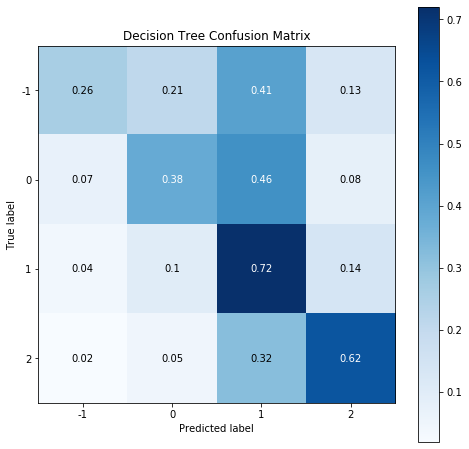

In [15]:
print('\nDecision Tree\n', classification_report(y_val, tree_prediction))
plot_confusion_matrix(y_val, tree_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

### Key Observations
A Classification report is used to measure the quality of predictions from a classification algorithm.

+ We can see a precision of 69% for pro climate which is higher,followed by news,neutral and anti climate change.
+ The precision for anti climate change and neutral are lower as compared to the models that we have tried. 

+ The recall values for the pro climate class of 72% is the highest.

+ Neutral in recall is as low as 4%.



The confusion matrix heatmap shows the recall score for each sentiment class.


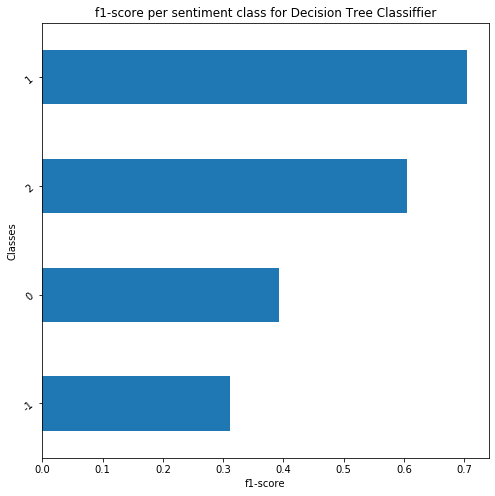

In [16]:
# # Visual represetation of of the f1 score for each class
report_tree = classification_report(y_val, tree_prediction, output_dict=True)
df_tree = pd.DataFrame(report_tree).transpose()
df_tree.drop(['accuracy'], inplace = True)
df_tree.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tree.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for Decision Tree Classiffier')
plt.show()

### Key Observations
The above bar graph shows the f1 score for each sentiment class using the Decision Tree classifier
- We see that the decision tree model did a very good job at classifiying `Pro climate change` tweets, followed by `News` and `Neutral` respectively.
- The Decision Tree classifier did a poor job at classifiying `Anti climate Change` tweets with an f1 score that is below 0.3.
- Poor classification of `Anti climate change` tweets is expected given the imbalance in our train data where we see that `Anti climate change` tweets only account for 8% of all tweets in the train dataset.

In [17]:
# Print the overall accuracy
decison_tree_acc = round(accuracy_score(y_val, tree_prediction),4)
print(f'\nOverall Accuracy score for Decision Tree : {decison_tree_acc}')
decision_tree_f1 = round(f1_score(y_val, tree_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score Decision Tree {decision_tree_f1}' )



Overall Accuracy score for Decision Tree : 0.6094

Weighted avg f1 score Decision Tree 0.6034


### Evalution of RandomForestClassifier

In [18]:
print('\nRandomForestClassifier\n', confusion_matrix(y_val, rfc_prediction))



RandomForestClassifier
 [[  46   36  287   20]
 [   2  208  457   39]
 [   1   53 2323  182]
 [   0    5  331  756]]



RandomForestClassifier
               precision    recall  f1-score   support

          -1       0.94      0.12      0.21       389
           0       0.69      0.29      0.41       706
           1       0.68      0.91      0.78      2559
           2       0.76      0.69      0.72      1092

    accuracy                           0.70      4746
   macro avg       0.77      0.50      0.53      4746
weighted avg       0.72      0.70      0.67      4746



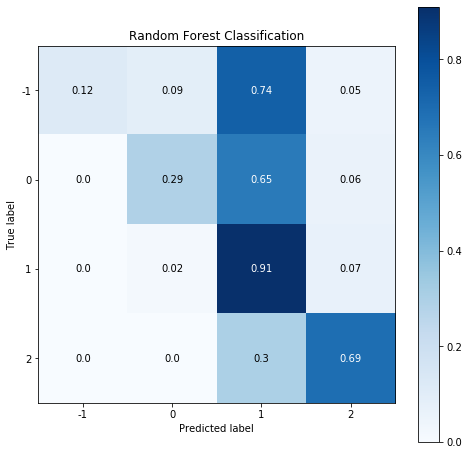

In [19]:
print('\nRandomForestClassifier\n', classification_report(y_val, rfc_prediction))
plot_confusion_matrix(y_val, rfc_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Random Forest Classification')
plt.show()

### Key Observations

We can see a precision of 72% for anti climate, 71% of neutral and news of 75% which is higher compared to `Decision Tree`.

The recall values for the pro climate class of 91% and news of 70% are the highest compared to `Decision Tree`.

Anti climate in recall dropped as compared to `Decision Tree`

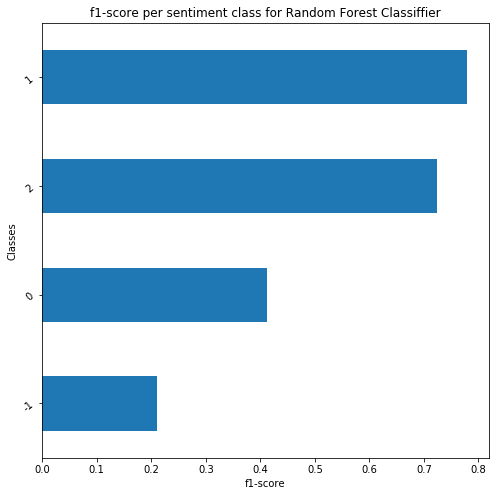

In [20]:
# # Visual represetation of of the f1 score for each class
report_rfc = classification_report(y_val, rfc_prediction, output_dict=True)
df_rfc = pd.DataFrame(report_rfc).transpose()
df_rfc.drop(['accuracy'], inplace = True)
df_rfc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_rfc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for Random Forest Classiffier')
plt.show()

### Key Observations
The above bar graph shows the f1 score for each sentiment class using the Random Forest classifier
- We see that the Random Forest model did a better job at classifiying `Pro climate change` tweeets and  `News`  comapred to the Decision tree model, with both the `Pro climate` and `News` sentimetents scoring over 0.7. and `Neutral` tweets following after that
- The Random Forest classifier did a poor job at classifiying `Anti climate Change` tweets with an f1 score lower than the one we got using the `Decision Tree` classifier.

In [21]:
random_forest_acc = round(accuracy_score(y_val, rfc_prediction),4)
print(f'\nOveral accuracy score for RandomForestClassifier :{random_forest_acc}')
random_forest_f1 = round(f1_score(y_val, rfc_prediction, average="weighted"),4)
print(f'\nWeighted f1 score for RandomForestClassifier : {random_forest_f1}')


Overal accuracy score for RandomForestClassifier :0.7023

Weighted f1 score for RandomForestClassifier : 0.6657


### Evaluation of LinearSVClassifier

In [22]:
print('\nLinearSVC Model\n', confusion_matrix(y_val, Lsvc_prediction))


LinearSVC Model
 [[ 158   53  148   30]
 [  31  265  340   70]
 [  35   95 2203  226]
 [   6   15  191  880]]



LinearSVC Model
               precision    recall  f1-score   support

          -1       0.69      0.41      0.51       389
           0       0.62      0.38      0.47       706
           1       0.76      0.86      0.81      2559
           2       0.73      0.81      0.77      1092

    accuracy                           0.74      4746
   macro avg       0.70      0.61      0.64      4746
weighted avg       0.73      0.74      0.72      4746



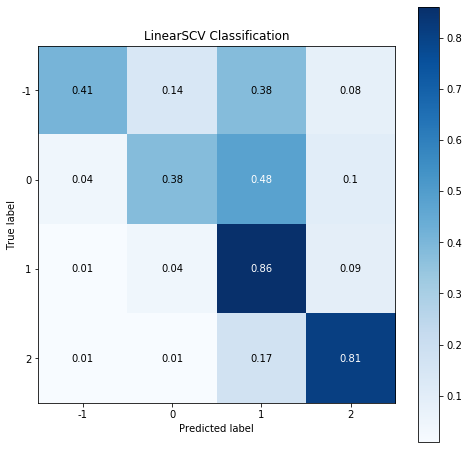

In [23]:
print('\nLinearSVC Model\n', classification_report(y_val, Lsvc_prediction))
plot_confusion_matrix(y_val, Lsvc_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('LinearSCV Classification')
plt.show()

### Key Observations

+ We can see a precision of 69% for anti climate which is higher compared to `Decision Tree` but it dropped compared to `Random Forest`.
+ Precision of 69% for pro climate which is higher compared to `Decision Tree` and `Random Forest`.

+ The recall value for the news class of 81% is the highest compared to `Decision Tree` and `Random Forest`
+ The recall value for the pro climate class  dropped compared to  `Random Forest`
+ Anti climate in recall increased as compared to `Random Forest` and `Decision Tree`

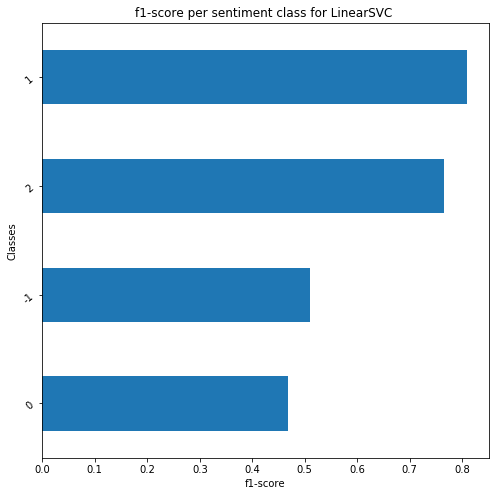

In [24]:
# # Visual represetation of of the f1 score for each class
report_svc = classification_report(y_val, Lsvc_prediction, output_dict=True)
df_svc = pd.DataFrame(report_svc).transpose()
df_svc.drop(['accuracy'], inplace = True)
df_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for LinearSVC ')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the LinearSVC
- We see that the LinearSVC model did a far better job at classifiying `Pro climate change` tweeets  compared to `Decision Tree` and `RandomForest` models  with the f1 score of label 1 sentiment class of over 0.8.
- The LinearSVC model also did a far better job at classifying `News` tweets comapred to both the Decision tree model and RandomForest model with the highest score level 2 sentiment class of over 0.75.
- We also see aa huge improvement in the classification of `Anti climate change` tweets with an f1 score just over 0.5, increasing from just below 0.3 that we saw with the `Decision Tree` classifier 
- There was a slight improvement in the classification of `neutral` tweets with the LinearSVC, which is by far overshadowed by the improvements we see in other sentiments classes

In [25]:
linearSVC_acc = round(accuracy_score(y_val, Lsvc_prediction),4)
print(f'\nOverall accuracy score for LinearSVC Model : {linearSVC_acc}')
linearSVC_f1 = round(f1_score(y_val, Lsvc_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for LinearSVC Model : {linearSVC_f1}')


Overall accuracy score for LinearSVC Model : 0.7387

Weighted avg f1 score for LinearSVC Model : 0.7242


### Evaluation of LGBMClassifier

In [26]:
print('\nLightGBM\n', confusion_matrix(y_val, lgbm_prediction))


LightGBM
 [[  89   64  208   28]
 [  14  292  355   45]
 [  27  132 2160  240]
 [   4   26  261  801]]



LightGBM
               precision    recall  f1-score   support

          -1       0.66      0.23      0.34       389
           0       0.57      0.41      0.48       706
           1       0.72      0.84      0.78      2559
           2       0.72      0.73      0.73      1092

    accuracy                           0.70      4746
   macro avg       0.67      0.55      0.58      4746
weighted avg       0.69      0.70      0.69      4746



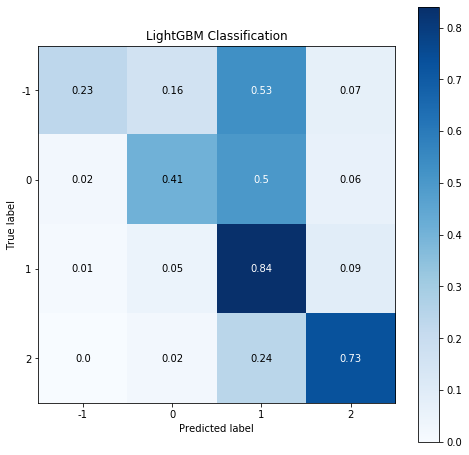

In [27]:
print('\nLightGBM\n', classification_report(y_val, lgbm_prediction))
plot_confusion_matrix(y_val, lgbm_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('LightGBM Classification')
plt.show()

 ### Key Observations

+ We can see a precision of 66% for anti climate and neutral dropped compared to `LinearSVC` and `Random Forest`. but increased compared to `Decision Tree`

+ The recall values for the pro climate class of 84% dropped compared to `LinearSVC` and `Random Forest` but it has increased compared to `Decision Tree`.
+ The neutral class in recall increased as compared to `Random Forest`, `LinearSVC` and `Decision Tree`

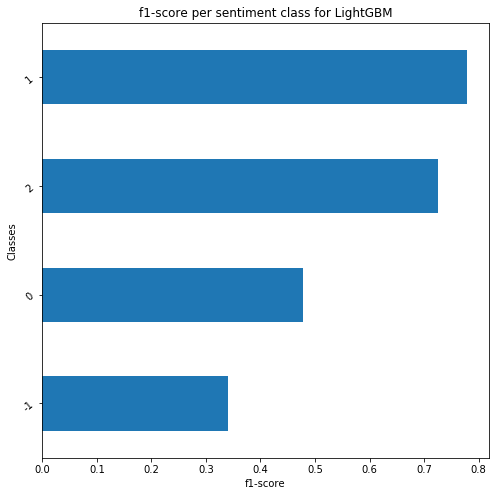

In [28]:
# # Visual represetation of of the f1 score for each class
report_lgbm = classification_report(y_val, lgbm_prediction, output_dict=True)
df_lgbm = pd.DataFrame(report_lgbm).transpose()
df_lgbm.drop(['accuracy'], inplace = True)
df_lgbm.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_lgbm.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for LightGBM')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the LightGBM
- Although the LightGBM model did a far better job at classifying `Pro climate tweets` and `News` compared to `Decision Tree` and `Random Forest` it is not as good as the `LinearSVC`
- We see a slight increase in the classification of `neutral` tweets compared to the classification of `LienarSVC`
- We see that the classification of `Anti climate change` tweets for `LightGBM` has decreased compared to `LinearSVC`, howver `LightGBM` still classifies the `Anti climate change` sentiment class better compared to the first two models we tried `Decision Tree` and `Random Forest` 

In [29]:
lGBM_acc = round(accuracy_score(y_val, lgbm_prediction),4)
print(f'\nOverall accuracy score for LightGBM :{lGBM_acc}')
lGBM_f1 = round(f1_score(y_val, lgbm_prediction, average="weighted"),4)
print(f'\nWeighted f1 score for LightGBM :{lGBM_f1}')


Overall accuracy score for LightGBM :0.7042

Weighted f1 score for LightGBM :0.6864


# Evaluation of  Logistic Regression 

In [30]:
# Report the confusion matrix
print('\nLogistic Regression\n', confusion_matrix(y_val, logreg_prediction))


Logistic Regression
 [[  91   39  230   29]
 [  13  207  411   75]
 [  10   47 2279  223]
 [   5    4  223  860]]



Logistic Regression
               precision    recall  f1-score   support

          -1       0.76      0.23      0.36       389
           0       0.70      0.29      0.41       706
           1       0.73      0.89      0.80      2559
           2       0.72      0.79      0.75      1092

    accuracy                           0.72      4746
   macro avg       0.73      0.55      0.58      4746
weighted avg       0.72      0.72      0.70      4746



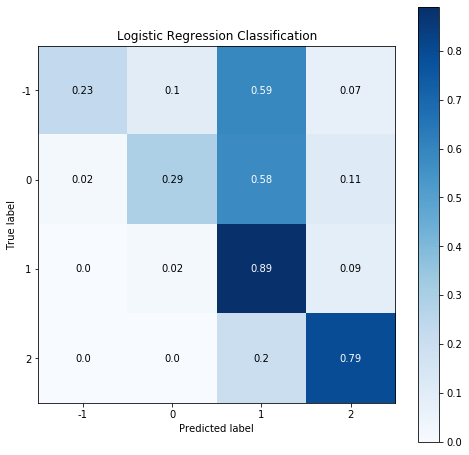

In [31]:
# Print a classification report

print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction))
plot_confusion_matrix(y_val, logreg_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Logistic Regression Classification')
plt.show()



 ### Key Observations

+ We can see a precision of 76% for anti climate which is higher compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest`.

+ The recall values for the pro climate class of 89% is the highest compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest`
+ Anti climate in recall is the same as `LGBMClassifier` and it has increased as compared to `Random Forest` and `Logistic Regression` but is has dropped as compared to `LinearSVC` and `Decision Tree`

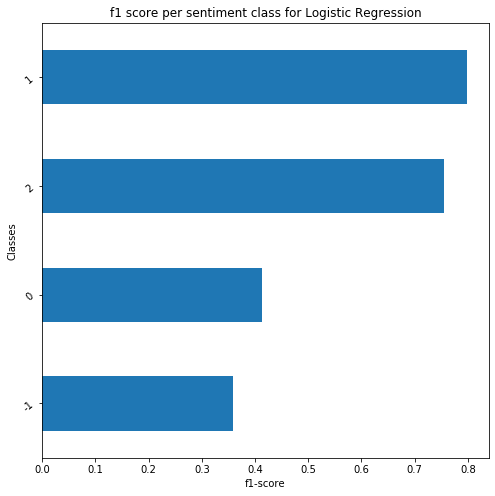

In [32]:
# # Visual represetation of of the f1 score for each class
report_logreg = classification_report(y_val, logreg_prediction, output_dict=True)
df_logreg = pd.DataFrame(report_logreg).transpose()
df_logreg.drop(['accuracy'], inplace = True)
df_logreg.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_logreg.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1 score per sentiment class for Logistic Regression')
plt.show()

In [33]:
# Print the overall accuracy
logistic_reg_acc = round(accuracy_score(y_val, logreg_prediction),4)
print('\nLogistic Regression accuracy Score\n', logistic_reg_acc)
logistic_reg_f1 = round(f1_score(y_val, logreg_prediction, average="weighted"),4)
print('\nLogistic Regression weighted f1 score\n', logistic_reg_f1)



Logistic Regression accuracy Score
 0.7242

Logistic Regression weighted f1 score
 0.6954


# Evaluation of SGD Classifier

In [34]:
# Confusion matrix for the random forest classifier
print('\nSGD Classifier\n', confusion_matrix(y_val, SGD_prediction))


SGD Classifier
 [[ 139   33  185   32]
 [  19  228  379   80]
 [  20   54 2250  235]
 [   7    3  210  872]]



SGD Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.75      0.36      0.48       389
           0       0.72      0.32      0.45       706
           1       0.74      0.88      0.81      2559
           2       0.72      0.80      0.75      1092

    accuracy                           0.74      4746
   macro avg       0.73      0.59      0.62      4746
weighted avg       0.73      0.74      0.71      4746



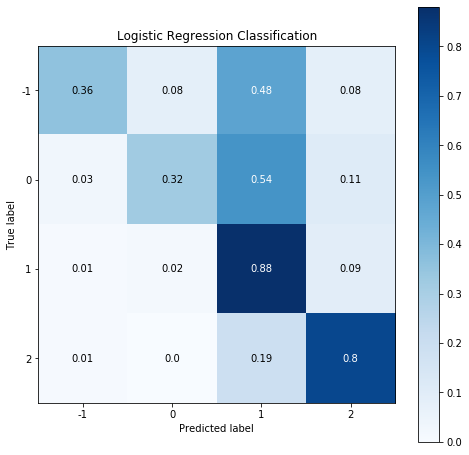

In [35]:
# The classification report 
print('\nSGD Classifier  Classification report :\n', classification_report(y_val, SGD_prediction))
plot_confusion_matrix(y_val, SGD_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Logistic Regression Classification')
plt.show()


### Key Observations

+ We can see a precision of anti and neutral are higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier` and `Logistic Regression`. it is not more than the anti climate of `Random Forest` but more than neutral.
+ The precision value for the news class dropped compared to the  `Decision Tree`

+ -The recall value for the pro climate class of 88% is the highest compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest` and `Logistic Regression`.
+ Anti climate has increased in recall as compared to `Decision Tree`, `Random Forest`, `LGBMClassifier` and `Logistic Regression` but is has dropped as compared to `LinearSVC`
+ Neural has dropped in recall as compared to `Decision Tree`, `LinearSVC`and  `LGBMClassifier` but is has dropped as compared to `Random Forest` and `Logistic Regression`

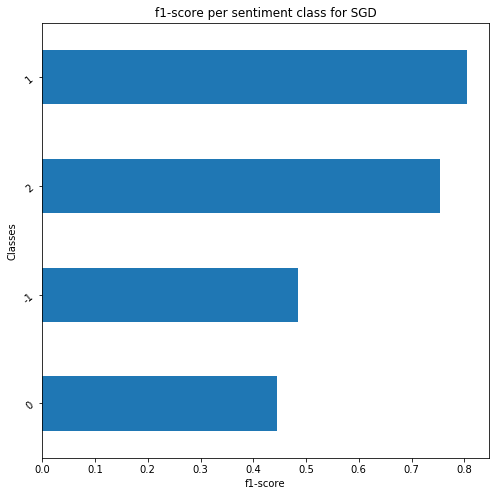

In [36]:
# # Visual represetation of of the f1 score for each class
report_sgd = classification_report(y_val, SGD_prediction, output_dict=True)
df_sgd = pd.DataFrame(report_sgd).transpose()
df_sgd.drop(['accuracy'], inplace = True)
df_sgd.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_sgd.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for SGD')
plt.show()

In [37]:
# Checking the accuracy score
sgd_acc = round(accuracy_score(y_val, SGD_prediction),4)
print('\nSGD Classifier accuracy Score :\n', sgd_acc)

# Checking the f1_score report for the decison tree model
sgd_f1 = round(f1_score(y_val, SGD_prediction, average="weighted"),4)
print('\nSGD weighted avg f1_score :\n', sgd_f1)


SGD Classifier accuracy Score :
 0.7351

SGD weighted avg f1_score :
 0.7142


# Support Vector Classfifier

In [38]:
# Confusion matrix for the random forest classifier
print('\nSupport Vector Classifier\n', confusion_matrix(y_val, SVC_prediction))


Support Vector Classifier
 [[  78   24  265   22]
 [   7  175  460   64]
 [   6   28 2318  207]
 [   3    1  229  859]]



Support Vector Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.83      0.20      0.32       389
           0       0.77      0.25      0.37       706
           1       0.71      0.91      0.80      2559
           2       0.75      0.79      0.77      1092

    accuracy                           0.72      4746
   macro avg       0.76      0.54      0.56      4746
weighted avg       0.74      0.72      0.69      4746



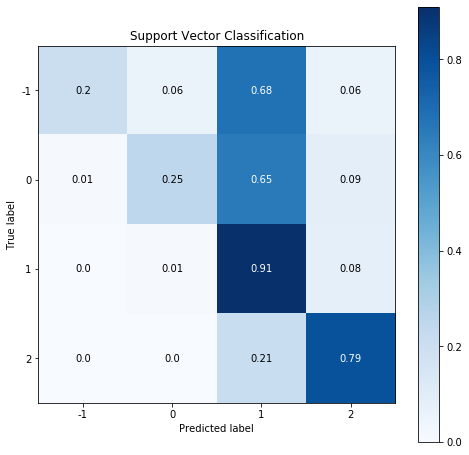

In [39]:
# The classification report 
print('\nSupport Vector Classifier  Classification report :\n', classification_report(y_val, SVC_prediction))
plot_confusion_matrix(y_val, SVC_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Support Vector Classification')
plt.show()


### Key Observations

+ We can see a precision of anti climate is higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier`. it is not more than the anti climate of `Random Forest`.


+ The recall value for the pro climate class of 91% is the same as `Random Forest` and higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier`.
+ Anti climate has dropped in recall as compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier` but is has increased as compared to `Random Forest`

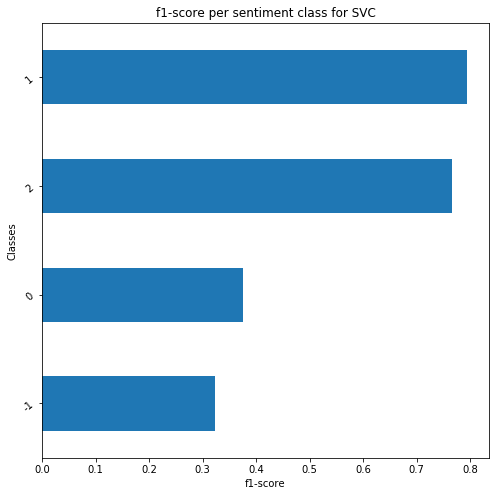

In [40]:
# # Visual represetation of of the f1 score for each class
report_svc = classification_report(y_val, SVC_prediction, output_dict=True)
df_SVC = pd.DataFrame(report_svc).transpose()
df_SVC.drop(['accuracy'], inplace = True)
df_SVC.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_SVC.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for SVC')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the Support Vector Classifier(SVC)
- Much like the `LinearSVC` we see that the  the `SVC` does a really good job at classifying `Pro climate change` sentiment class with a score of 0.8, followed by the `News` sentiment class with an f1 score of over 0.75.
- Similar to most of the models we've tested thus far the  `Support Vector Classifer` struggled with classifying the `anti climate change` sentiment, scoring just over 0.3

In [41]:
# Checking the accuracy score
svc_acc = round(accuracy_score(y_val, SVC_prediction),4)
print(f'\nSupport Vector Classifier accuracy Score :{svc_acc}')
svc_f1 = round(f1_score(y_val, SVC_prediction, average="weighted"),4)
print(f'\nSupport Vector Classifier weighted avg f1_score :{svc_f1}')


Support Vector Classifier accuracy Score :0.7227

Support Vector Classifier weighted avg f1_score :0.6871


### Model Comparision

Model comparison by accuracy and macro f1_score

In [42]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC',
                                    'LGBM','Logistic Regression','Stochastic Gradient Descent','Support Vector Classifier'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,lGBM_acc,logistic_reg_acc, sgd_acc, svc_f1],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,lGBM_f1,logistic_reg_f1, sgd_f1, svc_f1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

,Classifiers,Accuracy,Weighted avg f1 Score
0,Decision Tree,0.6094,0.6034
6,Support Vector Classifier,0.6871,0.6871
1,Random Forest,0.7023,0.6657
3,LGBM,0.7042,0.6864
4,Logistic Regression,0.7242,0.6954
5,Stochastic Gradient Descent,0.7351,0.7142
2,LinearSVC,0.7387,0.7242


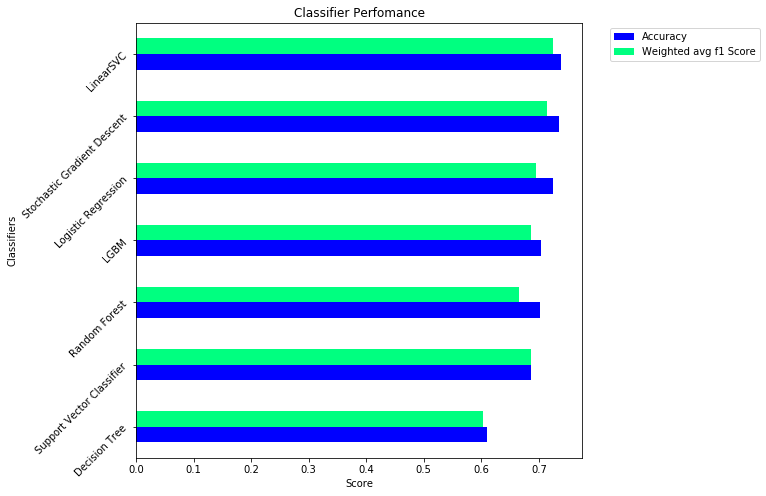

In [43]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='winter')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Key observations

From the above bar graph we see comparison of all the 7 models we've attempted thus far based on their `accuracy score` and associated `wighted f1 score`

- We see that our top 3 best performing models are `LinearSVC`,`Stochastic Gradient Descent` and `Logistic Regression` respectively, theres are the models will use in ensemble methods to try and improve our results
- The `Decision Tree` classifer is the worst  at classifying the tweets with the lowest accuracy and wighted f1 scores of 0.61 and 0.60 respectivey

**LinearSVC is the best performing model out of all 7 models that we've tried thus far with an accuracy score of 0.74 and a weighted f1 score of 0.72**

# Ensemble Methods

Ensemble learning in machine learning is the practice of combining multiple models to try and achieve higher overall model performance. In general, ensembles consist of multiple **heterogeneous or homogeneous** models trained on the same dataset. Each of these models is used to make predictions on the same input, then these predictions are aggregated across all models in some way (e.g. by taking the mean) to produce the final output.

<a id='ensemble'></a>
## Heterogeneous Ensembel Method
This type of ensemble consists of different types of models, so it can add pretty much any classification model we want, however in our case we're only going to add our top 3 best perfoming models which are, `LinearSVC, Stochastic Gradient Descent, Logistic Regression, `.

The Heterogeneous ensemble method we're going to look at is the `Voting classifier`


### Voting classifer 
Voting involves combining individual model outputs through a kind of "[majority rule](https://en.wikipedia.org/wiki/Majority_rule)" paradigm.
The diagram below shows how the `Voting Classifier` works
![ud382N9.png](https://iq.opengenus.org/content/images/2020/01/ud382N9.png)

In [44]:
# Define the models which we'll include in our ensemble. 
# We pass a list of tuples, which each have a string identifier for the
# model (arbitrary choice), along the actual instantiated sklearn model.  
models = [("LinearSVC",Lsvc),("SGD",SGD),("Logistric Regression",logreg)]

# Specify weights for weighted model averaging
model_weightings = np.array([0.1,0.3,0.6])

# building the voting classifier
Voting_classifier = VotingClassifier(estimators=models,weights=model_weightings)


In [45]:
# training the voting classifier
Voting_classifier.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('LinearSVC',
                              Pipeline(memory=None,
                                       steps=[('tfidf',
                                               TfidfVectorizer(analyzer='word',
                                                               binary=False,
                                                               decode_error='strict',
                                                               dtype=<class 'numpy.float64'>,
                                                               encoding='utf-8',
                                                               input='content',
                                                               lowercase=True,
                                                               max_df=1.0,
                                                               max_features=None,
                                                               min_df=1,
                                          

In [46]:
voting_prediction = Voting_classifier.predict(X_val) # Voting Classifier predictions

In [47]:
# The classification report 
print('\nVoting Classifier  Classification report :\n', classification_report(y_val, voting_prediction))
# plot_confusion_matrix(y_val, voting_prediction, normalize=True,figsize=(8,8),cmap='Blues')
# plt.title('Voting Classifier Classification')
# plt.show()


Voting Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.76      0.23      0.36       389
           0       0.70      0.29      0.41       706
           1       0.73      0.89      0.80      2559
           2       0.72      0.79      0.75      1092

    accuracy                           0.72      4746
   macro avg       0.73      0.55      0.58      4746
weighted avg       0.72      0.72      0.70      4746



In [48]:
# # # Visual represetation of of the f1 score for each class
# report_voting = classification_report(y_val, voting_prediction, output_dict=True)
# df_voting = pd.DataFrame(report_voting).transpose()
# df_voting.drop(['accuracy'], inplace = True)
# df_voting.sort_values(by=['f1-score'],ascending=True, inplace = True)
# df_voting.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
# plt.xlabel('f1-score')
# plt.ylabel('Classes')
# plt.yticks(rotation = 40)
# plt.title('f1-score per sentiment class for the voting classifier')
# plt.show()

In [49]:
# Checking the accuracy score
voting_acc = round(accuracy_score(y_val, voting_prediction),4)
print(f'\nOverall accuracy for the Voting Classifier :{voting_acc}')
voting_f1 = round(f1_score(y_val, voting_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for the Voting Classifier :{voting_f1}')


Overall accuracy for the Voting Classifier :0.7242

Weighted avg f1 score for the Voting Classifier :0.6954


## Homogeneous Ensembles

These consist of the same type of model. As such, a common way to promote diversity in model performance in these cases is to control the number of predictors or portion of data supplied to each model in the ensemble. Much like what happens in a random forest.

Some the most common methods for combining models in this way include **bagging** and **boosting**.

### Bagging (AKA Bootstrap Aggregating)

Bagging involves training the models of the ensemble on different subsets of the training data. Particularly on subsets which are **sampled with replacement** from the training data. As such, the resulting 'bag' of models are together more stable due to decreased variance error. 

The predictions are made by aggregating the predictions of all the models in the bag.
![1*JksRZ1E72Rsx2s8lQbNR1w.jpeg](https://miro.medium.com/max/875/1*JksRZ1E72Rsx2s8lQbNR1w.jpeg)

In [50]:
bag_class= Pipeline([('tfidf', TfidfVectorizer()),
                     ('bag', BaggingClassifier(base_estimator = LinearSVC())),])
 


In [51]:
bag_class.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                            class_weight=None,
                                                            dual=True,
                                                            fit_intercept=True,
                                                            intercept_sc

In [52]:
bag_prediction = bag_class.predict(X_val) # Bagging Classifier predictions

In [53]:
# The classification report 
print('\nBagging Classifier  Classification report :\n', classification_report(y_val, bag_prediction))
# plot_confusion_matrix(y_val, voting_prediction, normalize=True,figsize=(8,8),cmap='Blues')
# plt.title('Bagging Classifier Classification')
# plt.show()


Bagging Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.72      0.39      0.50       389
           0       0.62      0.38      0.47       706
           1       0.76      0.87      0.81      2559
           2       0.74      0.80      0.77      1092

    accuracy                           0.74      4746
   macro avg       0.71      0.61      0.64      4746
weighted avg       0.73      0.74      0.73      4746



In [54]:
# # Visual represetation of of the f1 score for each class
# report_bagging = classification_report(y_val, bag_prediction, output_dict=True)
# df_bag = pd.DataFrame(report_bagging).transpose()
# df_bag.drop(['accuracy'], inplace = True)
# df_bag.sort_values(by=['f1-score'],ascending=True, inplace = True)
# df_bag.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
# plt.xlabel('f1-score')
# plt.ylabel('Classes')
# plt.yticks(rotation = 40)
# plt.title('f1-score per sentiment class for the voting classifier')
# plt.show()

In [55]:
# Checking the accuracy score
bag_acc = round(accuracy_score(y_val, bag_prediction),4)
print(f'\nBagging Classifier accuracy Score :{bag_acc}')
bag_f1 = round(f1_score(y_val, bag_prediction, average="weighted"),4)
print(f'\nBagging Classifier weighted avg f1 score :{bag_f1}')


Bagging Classifier accuracy Score :0.741

Bagging Classifier weighted avg f1 score :0.7259


<a id='hy_tunning'></a>
# Hyperparameter Tunning
we will search for the best hyperparameters for our models using a GridSeachCV method.

* Models we will perform hyperparameter tunning on
  * LinearSVC
  * Logistic Regression
  * Support Vector Classifier
 

The caveat of using pipelines to build our models is that we can't easily get the parameters for our models as such to perfom hyperparameter tunning and obtain the best parameters for our modeks we wont be using the pipelines, this means we would have to convert raw text data to numeric using `TifidfVectorizer` independently from building the models

In [56]:
# Feature engineering

X_train_new= X_train.copy
X_val_new = X_val.copy()

vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf = True, max_df = 0.3, min_df = 5, ngram_range = (1, 2))
vectorizer.fit(X_train)

X_train_new = vectorizer.transform(X_train)
X_val_new = vectorizer.transform(X_val)

## Tuning LinearSVC

In [57]:
# The hyperprarameter gridsearch for the LinearSVC is purposefully commented out because 
# it perfoms 5 folds for each of the 9 candidates totalling in 45 fits, this GridSearch code took 27 minutes to complete

#  we have saved the resulting model as a pickle file for convinience


'''
param_grid = {'C': [0.2,0.3,0.4,0.5,1.0,3,3.01,10, 100]}
# grid_lsvc = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2)
# grid_lsvc.fit(X_train_new,y_train)

grid_lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])
                                                                     

grid_lsvc.fit(X_train,y_train)

# Saving the model
import pickle
model_save_path = 'LinearSVC.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(grid_lsvc, file)
    
''' 
 # loading the saved Logistic Regression model
model_load_path = 'LinearSVC.pkl'
with open(model_load_path, 'rb') as file:
    grid_lsvc=pickle.load(file)

In [58]:
tuned_lsvc_predictions = grid_lsvc.predict(X_val)

In [59]:
# Checking the accuracy score
tuned_lsvc_acc = round(accuracy_score(y_val, tuned_lsvc_predictions),4)
print(f'\nOverall accuracy score for LinearSVC :{tuned_lsvc_acc}')
tuned_lsvc_f1 = round(f1_score(y_val, tuned_lsvc_predictions, average="weighted"),4)
print(f'\nWeighted f1 score for LinearSVC :{tuned_lsvc_f1}')


Overall accuracy score for LinearSVC :0.7389

Weighted f1 score for LinearSVC :0.716


# Tuning Logistic Regression

In [60]:
# The hyperprarameter gridsearch for the logistic regression model is purposefully commented out because 
# it perfoms 5 folds for each of the 50 candidates totalling in 250 fits, this GridSearch  code took 3.6 minutes to complete
#  we have saved the resulting model as a pickle file


'''
param_grid = [
    {'penalty' : [ 'l2'],
    'C' : np.logspace(-4, 4, 50),
    'solver' : ['lbfgs']},]

Logistic_reg_grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=2)
Logistic_reg_grid.fit(X_train_new, y_train)


# Saving the model
import pickle
model_save_path = 'LogisticReg.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(logistic_grid, file)
    
  
 # loading the saved Logistic Regression model
model_load_path = 'LogisticReg.pkl'
with open(model_load_path, 'rb') as file:
    Logistic_reg_tuned=pickle.load(file)
    
    
best_parameters = {'C': 1000, 'penalty': 'l2', multi_class='ovr','solver': 'saga'}

'''


# Retraining the Logistic Regresion model with best parameters                     
logreg_tunned = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression(C=1000, multi_class='ovr', 
                                                                          solver='saga', random_state=11, max_iter=10)),])

In [61]:
logreg_tunned.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

In [62]:
tunned_logreg_acc = round(accuracy_score(y_val,logreg_tunned.predict(X_val)),4)
print(f'Overall accuracy score Tuned Logistic Regression accuracy Score :{tunned_logreg_acc}')

Overall accuracy score Tuned Logistic Regression accuracy Score :0.7408


In [63]:
tunned_logreg_f1 = round(f1_score(y_val, logreg_tunned.predict(X_val), average = 'weighted'),4)
print(f'Weighted avg f1 score for Tuned Logistic Regression Classifier :{tunned_logreg_f1}')

Weighted avg f1 score for Tuned Logistic Regression Classifier :0.7278


## Tuning Support Vector Classifier

In [64]:
# This code is purposefully commnted out because it Fits 5 folds for each of 72 candidates, totalling 360 fits
# the total runtime for this gridserch was 186 Minutes
# we have saved the model in a pickle file

'''

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

grid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])
                                                                     


param_grid = {'C': [0.1,1,3,3.01,10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])


                                                                     
                                                                                                                                 
# training the tunned model
grid.fit(X_train, y_train) 



best_params = {'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('grid',
   GridSearchCV(cv=None, error_score=nan,
                estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                              class_weight=None, coef0=0.0,
                              decision_function_shape='ovr', degree=3,
                              gamma='scale', kernel='rbf', max_iter=-1,
                              probability=False, random_state=None, shrinking=True,
                              tol=0.001, verbose=False),
                iid='deprecated', n_jobs=None,
                param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                            'kernel': ['rbf', 'poly', 'sigmoid']},
                pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
                scoring=None, verbose=2))]}




# Saving the model
import pickle
model_save_path = 'SVCGrid.pkl'
with open(model_save_path, 'wb') as file:
  pickle.dump(grid, file)
  
'''

# loading the saved model
model_load_path = 'SVCGrid.pkl'
with open(model_load_path, 'rb') as file:
    TunedSVC=pickle.load(file)
TunedSVC_prediction =TunedSVC.predict(X_val)

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid resu

In [65]:
# Checking the accuracy score
tunned_svc_acc = round(accuracy_score(y_val, TunedSVC_prediction),4)
print(f'\nOverall accuracy score for Tuned Support Vector Classifier accuracy Score :{tunned_svc_acc}')
tunned_svc_f1 = round(f1_score(y_val, TunedSVC_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for Tuned Support Vector Classifier :{tunned_svc_f1}')


Overall accuracy score for Tuned Support Vector Classifier accuracy Score :0.8226

Weighted avg f1 score for Tuned Support Vector Classifier :0.8173


# Final model selection

Comparing all the models we've build so far to choose the best performing one

In [66]:
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC',
                                    'LGBM','Logistic Regression','Stochastic Gradient Descent',
                                    'Support Vector Classifier', 'Voting Classifer','Bagging Classifier',
                                    'Tunned_LinearSVC','Tunned LogisticReg','Tunned_SVC'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,lGBM_acc,logistic_reg_acc, sgd_acc, svc_f1, voting_acc,
                                bag_acc,tuned_lsvc_acc ,tunned_logreg_acc,
                                tunned_svc_acc],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,lGBM_f1,logistic_reg_f1, sgd_f1, svc_f1,
                                              voting_f1, bag_f1, tuned_lsvc_f1 ,tunned_logreg_f1, 
                                              tunned_svc_f1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

,Classifiers,Accuracy,Weighted avg f1 Score
0,Decision Tree,0.6094,0.6034
6,Support Vector Classifier,0.6871,0.6871
1,Random Forest,0.7023,0.6657
3,LGBM,0.7042,0.6864
4,Logistic Regression,0.7242,0.6954
7,Voting Classifer,0.7242,0.6954
5,Stochastic Gradient Descent,0.7351,0.7142
2,LinearSVC,0.7387,0.7242
9,Tunned_LinearSVC,0.7389,0.7160
10,Tunned LogisticReg,0.7408,0.7278


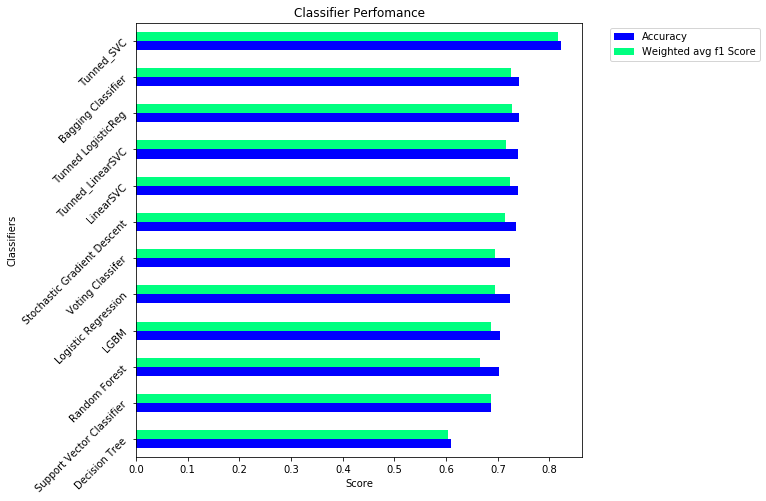

In [67]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='winter')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We have build a total of 11 models in this notebook out of all the models we've build, We see that the best performing model is the tunned Support Vector Classifer with the best accuracy score of 0.82 and the best weighted f1 score  of 82.

We will be using the **Support Vector Classifer** to make the final prediction.

## Final evaluation of our best model

In [68]:
print('classfication report for our best model\n',classification_report(y_val, TunedSVC.predict(X_val)))

classfication report for our best model
               precision    recall  f1-score   support

          -1       0.82      0.62      0.70       389
           0       0.78      0.58      0.66       706
           1       0.84      0.90      0.87      2559
           2       0.81      0.87      0.84      1092

    accuracy                           0.82      4746
   macro avg       0.81      0.74      0.77      4746
weighted avg       0.82      0.82      0.82      4746



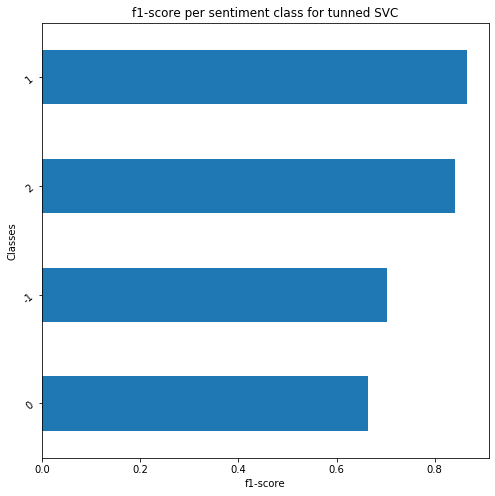

In [69]:
# # Visual represetation of of the f1 score for each class
report_tuned_svc = classification_report(y_val, TunedSVC_prediction, output_dict=True)
df_tuned_svc = pd.DataFrame(report_tuned_svc).transpose()
df_tuned_svc.drop(['accuracy'], inplace = True)
df_tuned_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tuned_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for tunned SVC')
plt.show()

The above bar graph shows the f1 score for each sentiment class our best model
- The Support Vector Classifier is by far our best performing model, achieving f1 score of 0.87 for `Pro climate change` sentiment class, followed by `News` and `Anti` Climate sentiment classes with f1 scores of 0.84 and 0.70 respectively, which is quite impressive given that all our models perfomed poorly when it comes to classifying `anti climate change` sentiment class


### ROC Curves and AUC

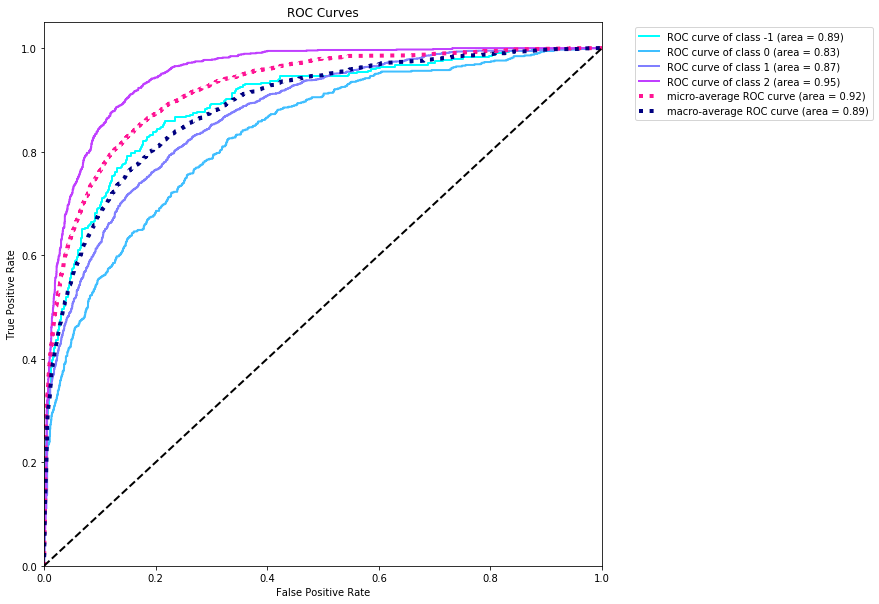

In [70]:
OneVsRest =  OneVsRestClassifier(SVC(class_weight='balanced'))
y_train_binarized = label_binarize(y_train, classes=[-1, 0, 1, 2])
y_val_binarized = label_binarize(y_val, classes=[-1, 0, 1, 2])
OneVsRest.fit(X_train_new, y_train_binarized)
y_prob = OneVsRest.decision_function(X_val_new)
plot_roc(y_val, y_prob,figsize=(10,10),cmap='cool')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<a id='predictions'></a>
# Final prediction

In [71]:
y_pred = TunedSVC.predict(X_test)

In [72]:
y_pred

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

In [73]:
test['sentiment'] = y_pred

In [74]:
#test[['tweetid','sentiment']].to_csv('SubmissionCSV.csv', index=False)

In [75]:
test[['tweetid','sentiment']]

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


# Closing the comet experiment

In [76]:
# close the experiment
#experiment.end()

In [77]:
#experiment.display()

<a id='conclusion'></a>
# Conclusion


<a id='appendix'></a>
# Appendix
* Things we did but couldnt fit anywhere in the notebook

## Hyperparameter tuning using parfit

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
grid = {
    'C' : np.logspace(-4, 4, 50),
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)
bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, paramGrid,
           X_train_new, y_train, X_val_new, y_val, 
           metric = accuracy_score,
           scoreLabel = "AUC")
print(bestModel, '\n',bestScore)

In [ ]:
# Test SGD
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], # learning rate
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train_new, y_train, X_val_new, y_val, 
           metric = accuracy_score,
           scoreLabel = "AUC")

print(bestModel,'\n\n' ,bestScore)

<a id='references'></a>
# References

TF-IDF Explained And Python Sklearn Implementation :
https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

Decision Trees Explained Easily :
https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248

Understanding Random Forests Classifiers in Python :
https://www.datacamp.com/community/tutorials/random-forests-classifier-python

What is LightGBM, How to implement it? How to fine tune the parameters?
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

Using word2vec embeddings as featrues :
https://www.kaggle.com/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut

A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

How to make SGD Classifier perform as well as Logistic Regression
https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

[Back to top ↑](#Top)